In [337]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,precision_recall_curve, roc_curve
from sklearn.metrics import roc_auc_score, PrecisionRecallDisplay, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve, validation_curve, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer, TargetEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from scipy.stats import loguniform,rankdata
import seaborn as sns
import matplotlib.pyplot as plt
import time
import shap



In [338]:
data = pd.read_csv('../datasets/titanic_preprocessed.csv')
print(data.head())
print(data.info())
print(data.describe())

X = data.drop('Survived', axis=1) # We `drop` the target column from features
y = data['Survived']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # Splitting the data into training and testing sets 20% test size 80% train size


   Survived  Pclass  Sex       Age  ...  Cabin  Embarked  FamilySize  IsAlone
0         0       3    0  0.000000  ...      0         0    1.098612        0
1         1       1    1  0.509141  ...      1         1    1.098612        0
2         1       3    1  0.000000  ...      0         0    0.693147        1
3         1       1    1  0.359988  ...      1         0    1.098612        0
4         0       3    0  0.359988  ...      0         0    0.693147        1

[5 rows x 9 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    float64
 4   Fare        891 non-null    float64
 5   Cabin       891 non-null    int64  
 6   Embarked    891 non-null    int64  
 7   FamilySize  891 non-null    floa

In [339]:
# Training the Logistic Regression model
model = LogisticRegression(max_iter=5000, tol=1e-3, random_state=42)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Ensures each fold has the same proportion of classes as the whole dataset

# Defining hyperparameter grid for Grid Search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'], # solvers that support both l1 and l2 penalties
    'penalty': ['l1', 'l2']
}

# Defining hyperparameter distribution for Randomized Search
param_distributions = {
    'C': loguniform(1e-3,1e3),
    'penalty': ['l1','l2'],
    'solver': ['liblinear', 'saga']
}

# Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1, # Use all available cores
    verbose=1 # Print progress messages
)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1, 
    verbose=1,
    n_iter=50, # Number of parameter settings that are sampled
    random_state=42
)

# Measure the time taken for both searches

start_time = time.time()
grid_search.fit(X_train, y_train)
print(f"Grid Search took {time.time() - start_time:.2f} seconds")

start_time = time.time()
random_search.fit(X_train, y_train)
print(f"Randomized Search took {time.time() - start_time:.2f} seconds")

grid_model = grid_search.best_estimator_  # Best model from Grid Search
random_model = random_search.best_estimator_  # Best model from Randomized Search

y_pred_grid = grid_model.predict(X_test)
y_pred_random = random_model.predict(X_test)

# Evaluating Grid Search model
print("Grid Search Model Evaluation:")
print("Best Hyperparameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_grid))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_grid))

# Evaluating Randomized Search model
print("\nRandomized Search Model Evaluation:")
print("Best Hyperparameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_random))

# Confusion Matrix: actual vs predicted shows counts of TN, FP, FN, TP

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_random))

# Accuracy: how many predictions were correct
# Precision: of all positive predictions, how many were actually positive
# Recall: of all actual positives, how many were correctly predicted
# F1-Score: harmonic mean of precision and recall

print("Classification Report:\n", classification_report(y_test, y_pred_random))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Grid Search took 0.16 seconds
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Randomized Search took 0.25 seconds
Grid Search Model Evaluation:
Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.7932960893854749
Confusion Matrix:
 [[90 15]
 [22 52]]

Randomized Search Model Evaluation:
Best Hyperparameters: {'C': 0.04848496183873291, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.8044692737430168
Confusion Matrix:
 [[93 12]
 [23 51]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84       105
           1       0.81      0.69      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



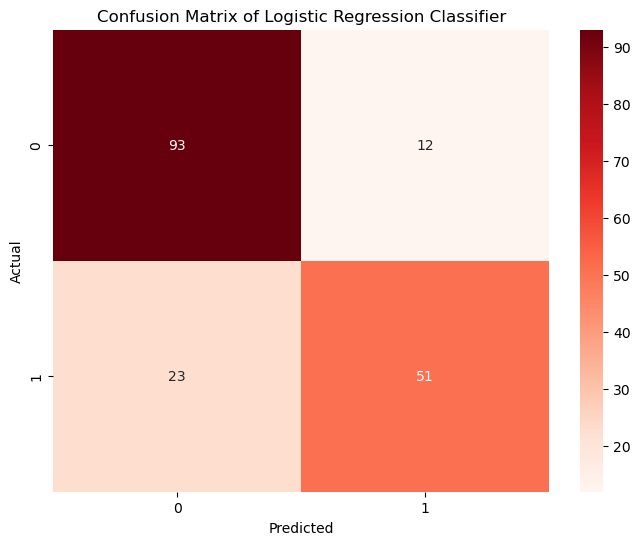

In [340]:
# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred_random)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Logistic Regression Classifier')
plt.show()


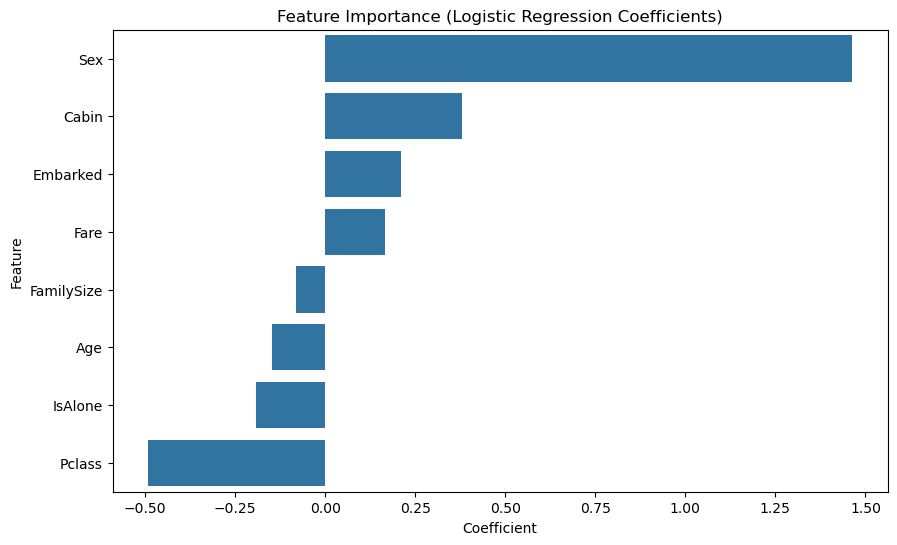

In [341]:
# Feature Importance: coefficients of the logistic regression model
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': random_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=coefficients, x='Coefficient', y='Feature')
plt.title("Feature Importance (Logistic Regression Coefficients)") 
plt.show()

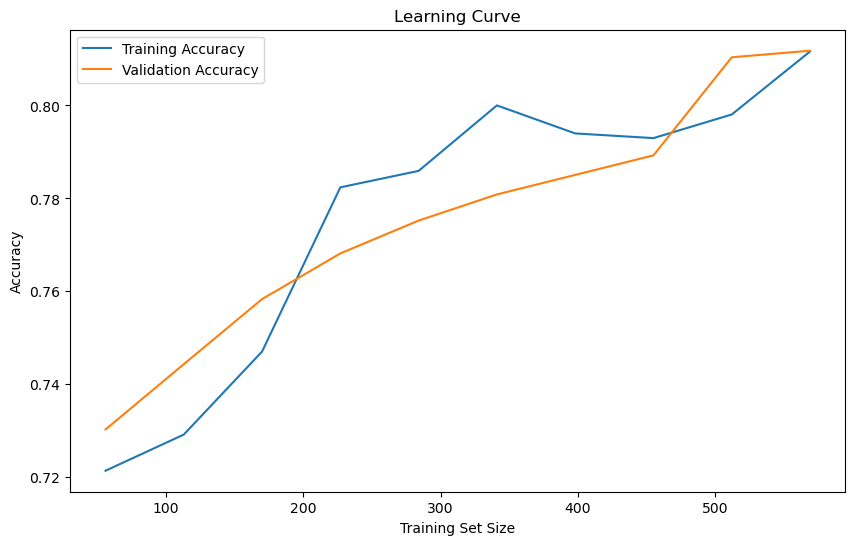

In [342]:
# Learning Curve: model performance vs training set size
learning_curves = learning_curve(
    estimator=random_model,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_sizes, train_scores, test_scores = learning_curves
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_scores_mean, label='Training Accuracy')
plt.plot(train_sizes, test_scores_mean, label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

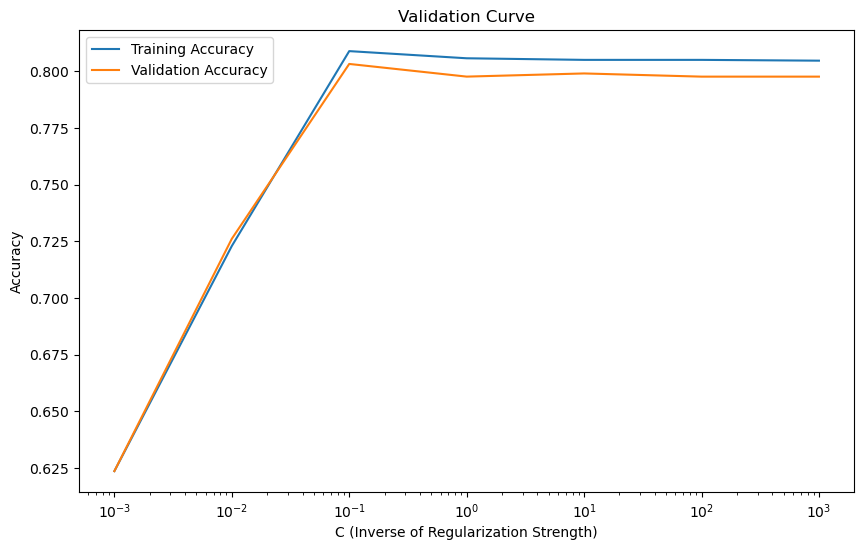

In [343]:
# Validation Curve: model performance vs hyperparameter values
param_range = np.logspace(-3, 3, 7)
validation_curves = validation_curve(
    estimator=random_model,
    X=X_train,
    y=y_train,
    param_name='C',
    param_range=param_range,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1
)

train_scores, test_scores = validation_curves
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10,6))
plt.semilogx(param_range, train_scores_mean, label='Training Accuracy')
plt.semilogx(param_range, test_scores_mean, label='Validation Accuracy')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Validation Curve')
plt.legend()
plt.show()

/home/manousos/anaconda3/envs/my_env/lib/python3.11/site-packages/sklearn/utils/_plotting.py:379: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(


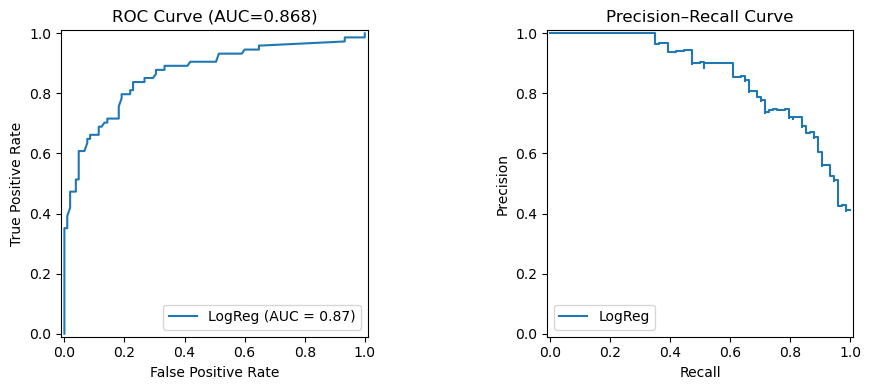

In [344]:
# Error Analysis (Visual Only)
if hasattr(random_model, "predict_proba"):
    y_proba = random_model.predict_proba(X_test)[:, 1]
elif hasattr(random_model, "decision_function"):
    scores = random_model.decision_function(X_test)
    ranks = pd.Series(scores, index=y_test.index).rank(method="average")
    y_proba = ((ranks - ranks.min()) / (ranks.max() - ranks.min())).to_numpy()
else:
    y_proba = y_pred_random.astype(float)

auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)
prec, rec, _ = precision_recall_curve(y_test, y_proba)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name="LogReg").plot(ax=axes[0])
axes[0].set_title(f"ROC Curve (AUC={auc:.3f})")
PrecisionRecallDisplay(precision=prec, recall=rec, estimator_name="LogReg").plot(ax=axes[1])
axes[1].set_title("Precision–Recall Curve")

plt.tight_layout()
plt.show()

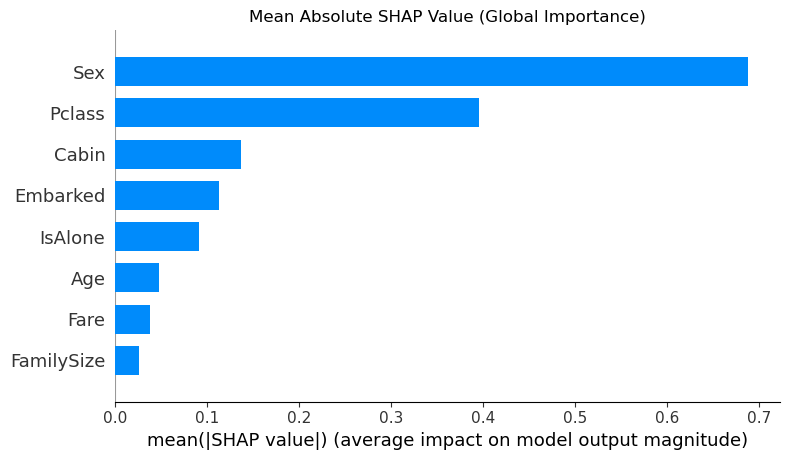

In [345]:
# SHAP Explanations
sample_size = 200  # adjust for speed vs detail
background = X_train.sample(min(sample_size, len(X_train)), random_state=42)
eval_sample = X_test.sample(min(sample_size, len(X_test)), random_state=42)
explainer = shap.LinearExplainer(random_model, background)
shap_values = explainer.shap_values(eval_sample)

shap.summary_plot(shap_values, eval_sample, plot_type='bar', show=False)
plt.title('Mean Absolute SHAP Value (Global Importance)')
plt.tight_layout()
plt.show()

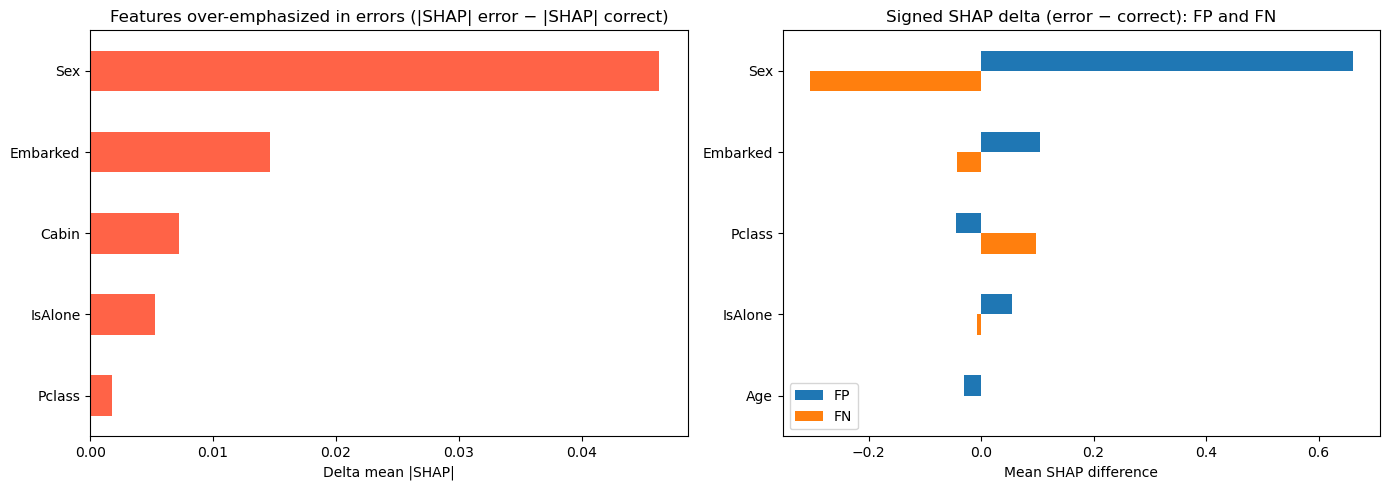

Top potentially harmful-by-overuse features:
Sex         0.046311
Embarked    0.014633
Cabin       0.007245
IsAlone     0.005280
Pclass      0.001791
dtype: float64


In [346]:
# SHAP on misclassifications (FP/FN): which features drive the mistakes?

sample_size = 200
background = X_train.sample(min(sample_size, len(X_train)), random_state=42)
explainer = shap.LinearExplainer(random_model, background)

# Evaluate on the full test set (or sample for speed)
eval_df = X_test.copy()
y_true = y_test.loc[eval_df.index]
y_pred = random_model.predict(eval_df)

# SHAP values for the evaluation slice
shap_vals = explainer.shap_values(eval_df)
if isinstance(shap_vals, list):  # some SHAP versions return list per class
    shap_vals = shap_vals[1] if len(shap_vals) > 1 else shap_vals[0]

shap_df = pd.DataFrame(shap_vals, index=eval_df.index, columns=eval_df.columns)

# Masks for error types
fp_mask = (y_true == 0) & (y_pred == 1)
fn_mask = (y_true == 1) & (y_pred == 0)
correct_mask = ~fp_mask & ~fn_mask

# Aggregate mean absolute contributions
mean_abs_fp = np.abs(shap_df[fp_mask.values]).mean() if fp_mask.any() else pd.Series(0, index=shap_df.columns)
mean_abs_fn = np.abs(shap_df[fn_mask.values]).mean() if fn_mask.any() else pd.Series(0, index=shap_df.columns)
mean_abs_correct = np.abs(shap_df[correct_mask.values]).mean() if correct_mask.any() else pd.Series(0, index=shap_df.columns)

# Directional differences (error vs correct)
signed_fp = shap_df[fp_mask.values].mean() if fp_mask.any() else pd.Series(0, index=shap_df.columns)
signed_fn = shap_df[fn_mask.values].mean() if fn_mask.any() else pd.Series(0, index=shap_df.columns)
signed_correct = shap_df[correct_mask.values].mean() if correct_mask.any() else pd.Series(0, index=shap_df.columns)

# Features whose absolute impact is larger in errors than in correct predictions are suspect
error_overuse_score = ((mean_abs_fp + mean_abs_fn)/2 - mean_abs_correct).sort_values(ascending=False)

# Plot top 5 by error_overuse_score
k = min(5, len(error_overuse_score))
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
error_overuse_score.head(k).plot(kind='barh', ax=axes[0], color='tomato')
axes[0].invert_yaxis()
axes[0].set_title('Features over-emphasized in errors (|SHAP| error − |SHAP| correct)')
axes[0].set_xlabel('Delta mean |SHAP|')

# Directionality: where errors systematically push the wrong way vs correct
delta_fp = (signed_fp - signed_correct)
delta_fn = (signed_fn - signed_correct)

# Combine by max abs per feature to highlight strongest misdirection
misdirection = pd.concat({'FP': delta_fp, 'FN': delta_fn}, axis=1)
misdirection['max_abs'] = misdirection.abs().max(axis=1)
misdirection_sorted = misdirection.sort_values('max_abs', ascending=False).drop(columns=['max_abs'])

misdirection_sorted.head(k).plot(kind='barh', ax=axes[1])
axes[1].invert_yaxis()
axes[1].set_title('Signed SHAP delta (error − correct): FP and FN')
axes[1].set_xlabel('Mean SHAP difference')
plt.tight_layout()
plt.show()

print('Top potentially harmful-by-overuse features:')
print(error_overuse_score.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int6

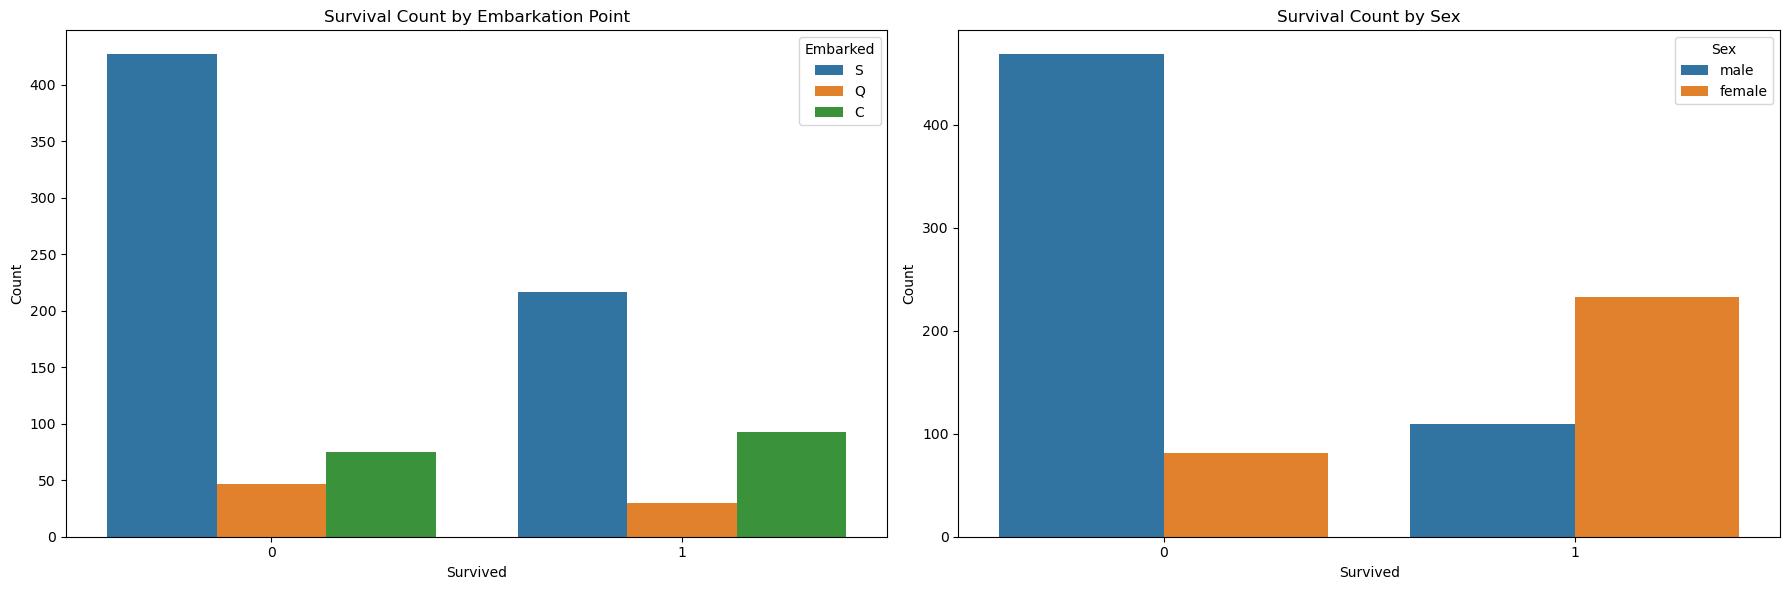

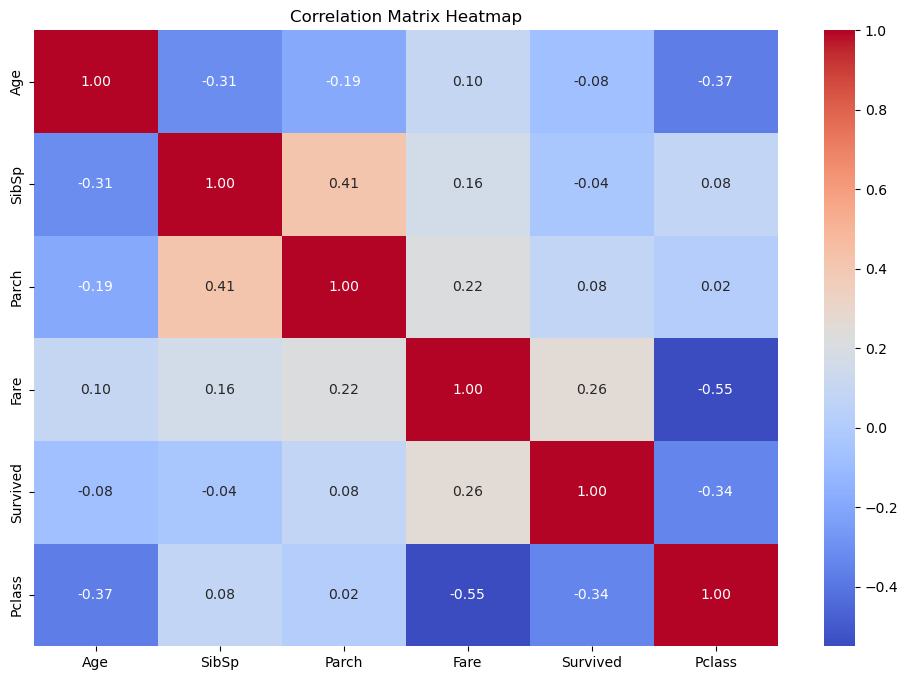

In [347]:
# Data Analysis and Visualization

new_data = pd.read_csv('../datasets/Titanic-Dataset.csv')
print(new_data.info())
print(new_data.isna().sum())

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Visualizing Survival Count by Embarkation Point
sns.countplot(data=new_data, x='Survived', hue='Embarked', ax=axes[0])
axes[0].set_title('Survival Count by Embarkation Point')
axes[0].set_xlabel('Survived')
axes[0].set_ylabel('Count')

# Visualizing Survival Count by Sex
sns.countplot(data=new_data, x='Survived', hue='Sex', ax=axes[1])
axes[1].set_title('Survival Count by Sex')
axes[1].set_xlabel('Survived')
axes[1].set_ylabel('Count')
axes[1].legend(title='Sex')
plt.tight_layout()
plt.show()

numerical_features = ['Age', 'SibSp', 'Parch', 'Fare', 'Survived', 'Pclass']

# Heatmap of Correlation Matrix
plt.figure(figsize=(12,8))
corr_matrix = new_data[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [348]:
# Feature Engineering Pipeline

def feature_engineering_pipeline(X):
    X_processed = X.copy()

    # Drop irrelevant features
    X_processed = X_processed.drop(['Name', 'Ticket', 'PassengerId'], axis=1)

    # Handle missing values
    X_processed['Age'] = X_processed['Age'].fillna(X_processed['Age'].median())
    X_processed['Cabin'] = X_processed['Cabin'].fillna('Unknown')
    X_processed['Embarked'] = X_processed['Embarked'].fillna(X_processed['Embarked'].mode()[0])

    # Extract title from name (keep Embarked for interaction)
    X_processed['FamilySize'] = X_processed['SibSp'] + X_processed['Parch'] + 1
    X_processed['IsAlone'] = (X_processed['FamilySize'] == 1).astype(int)
    
    # Age grouping
    X_processed['AgeGroup'] = pd.cut(X_processed['Age'], bins=[-1, 12, 20, 40, 60, 100], labels=[0,1,2,3,4]).astype(int)
    
    # Fare per person
    X_processed['FarePerPerson'] = X_processed['Fare'] / X_processed['FamilySize']
    X_processed['FarePerPerson'] = X_processed['FarePerPerson'].fillna(X_processed['Fare'])

    # Encode categorical
    X_processed['Sex'] = X_processed['Sex'].map({'male': 0, 'female': 1})
    X_processed['Cabin'] = X_processed['Cabin'].apply(lambda x: 0 if x == 'Unknown' else 1)
    X_processed = pd.get_dummies(X_processed, columns=['Embarked'], drop_first=True)

    # Key interactions
    X_processed['Sex_Pclass'] = X_processed['Sex'] * X_processed['Pclass']
    X_processed['Age_Pclass'] = X_processed['Age'] * X_processed['Pclass']
    X_processed['Fare_Pclass'] = X_processed['Fare'] * X_processed['Pclass']
    
    # Scale numerics
    num_cols = ['Age', 'SibSp', 'Parch', 'Fare', 'FarePerPerson', 'FamilySize']
    scaler = StandardScaler()
    X_processed[num_cols] = scaler.fit_transform(X_processed[num_cols])

    return X_processed

In [349]:
# Hyperparameter Tuning and Model Training

X = new_data.drop('Survived', axis=1)
y = new_data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_eng = feature_engineering_pipeline(X_train)
X_test_eng = feature_engineering_pipeline(X_test)

model_eng = LogisticRegression(max_iter=5000, tol=1e-3, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search_eng = RandomizedSearchCV(
    estimator=model_eng,
    param_distributions=param_distributions,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1, 
    verbose=0,
    n_iter=50, 
    random_state=42
)

start_time = time.time()
random_search_eng.fit(X_train_eng, y_train)
print(f"Randomized Search took {time.time() - start_time:.2f} seconds")

model_eng_best = random_search_eng.best_estimator_
y_pred_eng = model_eng_best.predict(X_test_eng)
y_proba_eng = model_eng_best.predict_proba(X_test_eng)[:, 1]

print("\nEnhanced Model with Feature Engineering:")
print("Best Hyperparameters:", random_search_eng.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_eng))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_eng))
print("Classification Report:\n", classification_report(y_test, y_pred_eng))

Randomized Search took 0.99 seconds

Enhanced Model with Feature Engineering:
Best Hyperparameters: {'C': 36.7037376252939, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.8212290502793296
Confusion Matrix:
 [[95 10]
 [22 52]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.90      0.86       105
           1       0.84      0.70      0.76        74

    accuracy                           0.82       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



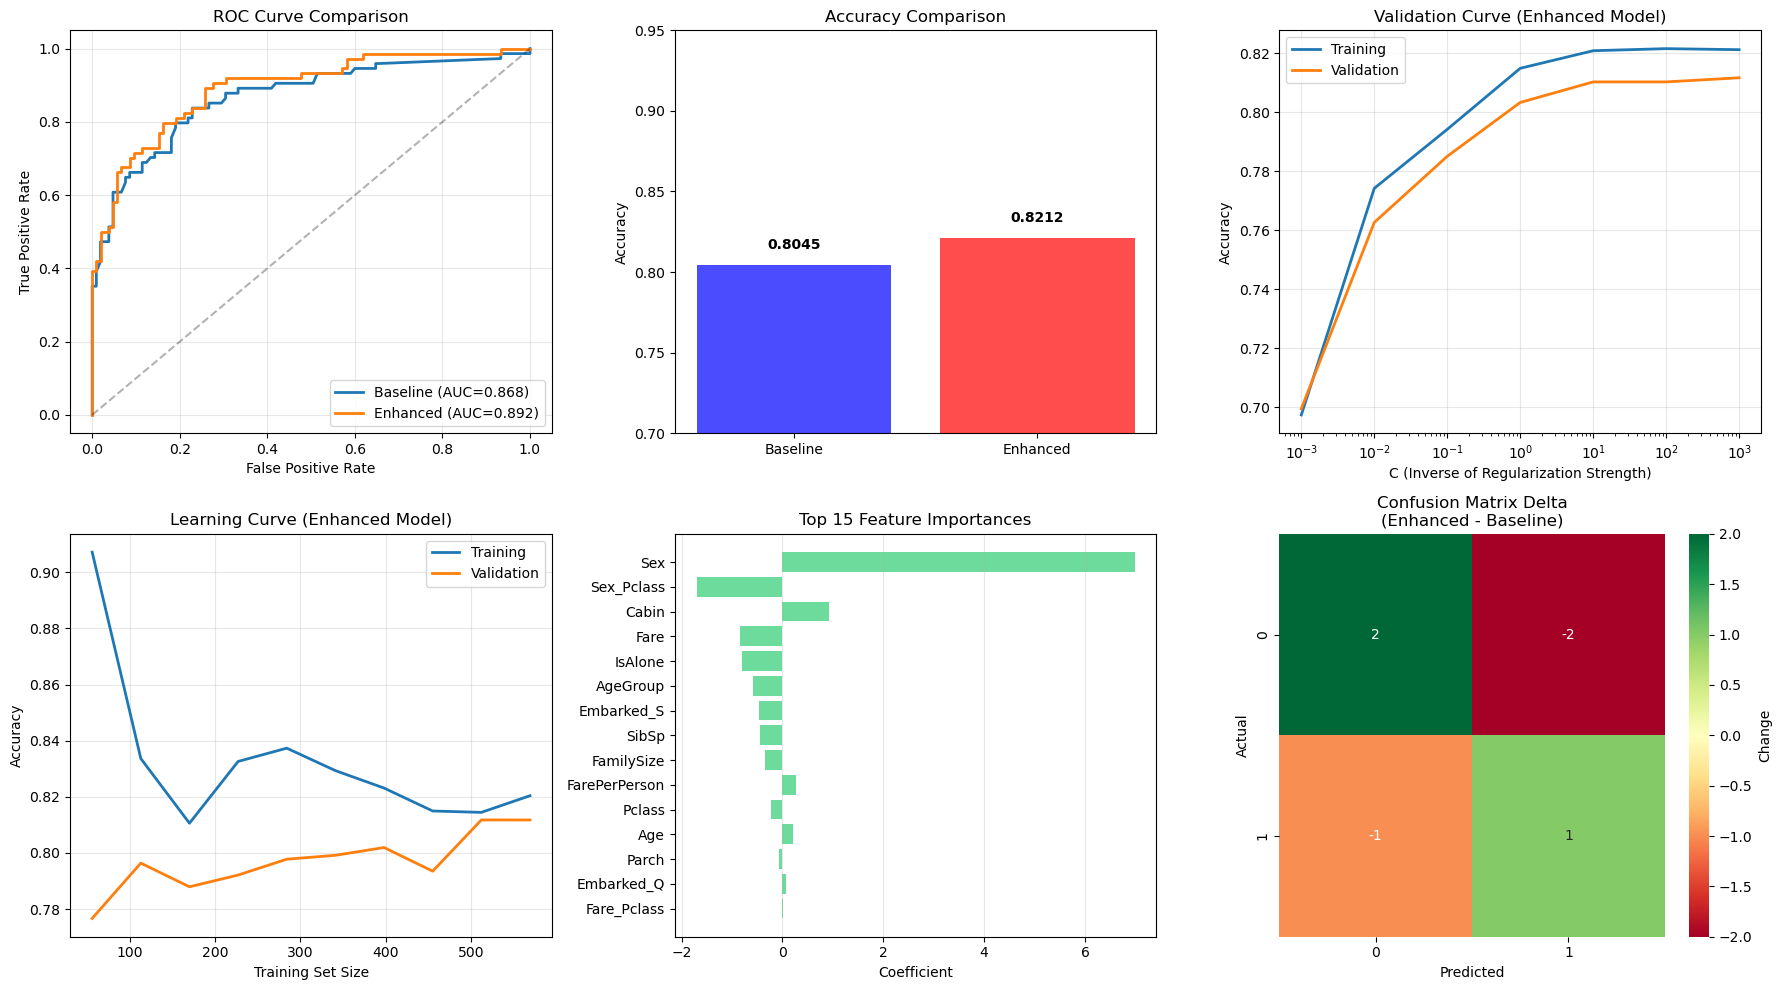

In [350]:
# Comprehensive Model Comparison

# Baseline model (from cell 3)
baseline_acc = accuracy_score(y_test, y_pred_random)
baseline_auc = roc_auc_score(y_test, y_proba)

# Enhanced model
enhanced_acc = accuracy_score(y_test, y_pred_eng)
enhanced_auc = roc_auc_score(y_test, y_proba_eng)

# Performance comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# ROC Curves
fpr_base, tpr_base, _ = roc_curve(y_test, y_proba)
fpr_enh, tpr_enh, _ = roc_curve(y_test, y_proba_eng)
axes[0,0].plot(fpr_base, tpr_base, label=f'Baseline (AUC={baseline_auc:.3f})', linewidth=2)
axes[0,0].plot(fpr_enh, tpr_enh, label=f'Enhanced (AUC={enhanced_auc:.3f})', linewidth=2)
axes[0,0].plot([0,1], [0,1], 'k--', alpha=0.3)
axes[0,0].set_xlabel('False Positive Rate')
axes[0,0].set_ylabel('True Positive Rate')
axes[0,0].set_title('ROC Curve Comparison')
axes[0,0].legend()
axes[0,0].grid(alpha=0.3)

# Accuracy comparison
models = ['Baseline', 'Enhanced']
accuracies = [baseline_acc, enhanced_acc]
colors = ['blue', 'red']
axes[0,1].bar(models, accuracies, color=colors, alpha=0.7)
axes[0,1].set_ylabel('Accuracy')
axes[0,1].set_title('Accuracy Comparison')
axes[0,1].set_ylim([0.7, 0.95])
for i, v in enumerate(accuracies):
    axes[0,1].text(i, v+0.01, f'{v:.4f}', ha='center', fontweight='bold')

# Validation Curve for Enhanced Model
param_range = np.logspace(-3, 3, 7)
vc_eng = validation_curve(
    estimator=model_eng_best,
    X=X_train_eng,
    y=y_train,
    param_name='C',
    param_range=param_range,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1
)

train_scores_eng, test_scores_eng = vc_eng
train_mean_eng = np.mean(train_scores_eng, axis=1)
test_mean_eng = np.mean(test_scores_eng, axis=1)
axes[0,2].semilogx(param_range, train_mean_eng, label='Training', linewidth=2)
axes[0,2].semilogx(param_range, test_mean_eng, label='Validation', linewidth=2)
axes[0,2].set_xlabel('C (Inverse of Regularization Strength)')
axes[0,2].set_ylabel('Accuracy')
axes[0,2].set_title('Validation Curve (Enhanced Model)')
axes[0,2].legend()
axes[0,2].grid(alpha=0.3)

# Learning curve for enhanced model
lc_eng = learning_curve(model_eng_best, X_train_eng, y_train, cv=skf, 
                         scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_sizes_eng, train_scores_eng, test_scores_eng = lc_eng
train_mean_eng = np.mean(train_scores_eng, axis=1)
test_mean_eng = np.mean(test_scores_eng, axis=1)


axes[1,0].plot(train_sizes_eng, train_mean_eng, label='Training', linewidth=2)
axes[1,0].plot(train_sizes_eng, test_mean_eng, label='Validation', linewidth=2)
axes[1,0].set_xlabel('Training Set Size')
axes[1,0].set_ylabel('Accuracy')
axes[1,0].set_title('Learning Curve (Enhanced Model)')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

# Feature importance (top 15)
coef_df = pd.DataFrame({
    'Feature': X_train_eng.columns,
    'Coefficient': model_eng_best.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False).head(15)

axes[1,1].barh(coef_df['Feature'], coef_df['Coefficient'], color='#2ecc71', alpha=0.7)
axes[1,1].set_xlabel('Coefficient')
axes[1,1].set_title('Top 15 Feature Importances')
axes[1,1].invert_yaxis()
axes[1,1].grid(axis='x', alpha=0.3)

# Confusion Matrix Delta (Enhanced - Baseline)
cm_base = confusion_matrix(y_test, y_pred_random)
cm_enh = confusion_matrix(y_test, y_pred_eng)
cm_delta = cm_enh - cm_base
sns.heatmap(cm_delta, annot=True, fmt='d', cmap='RdYlGn', center=0, ax=axes[1,2], cbar_kws={'label': 'Change'})
axes[1,2].set_xlabel('Predicted')
axes[1,2].set_ylabel('Actual')
axes[1,2].set_title('Confusion Matrix Delta\n(Enhanced - Baseline)')

plt.tight_layout()
plt.show()